In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data loading

In [296]:
data = pd.read_csv("./data.csv")
print(data.head)
print(data.shape)

<bound method NDFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pi

In [297]:
A = np.array(data)

X = A[:,1:].T
Y = A[:,0]

d, N = X.shape
print(f"{d=}, {N=}")

d=784, N=42000


## Dataset creation

In [298]:
def get_X_Y_of_digits(digits):
    X = A[:,1:].T
    Y = A[:,0]

    X_ks = []
    Ys = []
    for digit in digits:
        X_ks.append(X[:, Y == digit])
        Ys.append(Y[Y == digit])

    X = np.concatenate(X_ks, axis=1)
    Y = np.concatenate(Ys)

    return X, Y

def split_dataset(X, Y, N_train = 1000):

    d, N = X.shape

    indices = np.arange(N)
    np.random.shuffle(indices)

    train_indices = indices[:N_train]
    test_indices = indices[N_train:]

    X_train = X[:, train_indices]
    Y_train = Y[train_indices]

    X_test = X[:, test_indices]
    Y_test = Y[test_indices]

    return X_train, Y_train, X_test, Y_test




In [299]:
def centroid(X):
    centroid = np.mean(X, axis=1)
    return centroid.reshape((len(centroid), 1))

def calculate_centroids(X, Y, digits):
    centroids = []
    for digit in digits:
        centroids.append(centroid(X[:, np.equal(Y,digit)]))

    return np.array(centroids)


In [300]:
def average_cluster_distance(X, Y, centroids, digits):
    average_distances = {}
    for digit, centroid in zip(digits, centroids):
        X_digit = X[:, Y == digit]

        total_distance = 0
        for x in X_digit:
            total_distance = total_distance + np.linalg.norm(x - centroid, 2)


        average_distances[digit] = total_distance / X_digit.shape[1]
    return average_distances


In [301]:
digits = [0, 6, 9]
X, Y = get_X_Y_of_digits(digits)

X_train, Y_train, X_test, Y_test = split_dataset(X, Y, 5000)
print(f"{X_train.shape=}, {Y_train.shape=}, {X_test.shape=}, {Y_test.shape=}")
centroids = calculate_centroids(X_train, Y_train, digits)


X_train.shape=(784, 5000), Y_train.shape=(5000,), X_test.shape=(784, 7457), Y_test.shape=(7457,)


## PCA

In [302]:
def PCA_projection_matrix(X, k):
    X_centered = X - centroid(X)

    U, s, VT = np.linalg.svd(X_centered, full_matrices=False, )
    U_k = U[:, :k]

    return U_k

def PCA(X, k):
    X_centered = X - centroid(X)
    U_k = PCA_projection_matrix(X, k)

    return U_k.T @ X_centered


def test_pca(D, digits, fig = None):
    X_train, Y_train, X_test, Y_test = D

    Q_2d = PCA_projection_matrix(X_train, k=2)
    Z_k_2d = Q_2d.T @ X_train
    projected_centroids_2d = Q_2d.T @ centroids

    average_cluster_distance_2d = average_cluster_distance(Z_k_2d, Y_train, projected_centroids_2d, digits=digits)

    print("Cluster distance calculated in 2 dimension:")
    for digit, average_distance in average_cluster_distance_2d.items():
        print(f"Cluster of digit {digit} average distance from centroid in 2-Dimension: {average_distance}")

    if not fig:
        fig = plt.figure(figsize = (20, 10))

    ax = fig.add_subplot(1,2,1)



    ax.scatter(Z_k_2d[0,:], Z_k_2d[1, :], c=Y_train)
    ax.scatter(projected_centroids_2d[:, 0, :], projected_centroids_2d[:, 1, :], c = "red", marker = "x", s=150)

    Q_3d = PCA_projection_matrix(X_train, k=3)
    Z_k_3d = Q_3d.T @ X_train
    projected_centroids_3d = Q_3d.T @ centroids

    average_cluster_distance_3d = average_cluster_distance(Z_k_3d, Y_train, projected_centroids_3d, digits=digits)

    print("\nCluster distance calculated in 3 dimension:")
    for digit, average_distance in average_cluster_distance_3d.items():
        print(f"Cluster of digit {digit} average distance from centroid in 3-Dimension: {average_distance}")

    ax = fig.add_subplot(1,2,2, projection='3d')
    ax.scatter(Z_k_3d[0,:], Z_k_3d[1, :], Z_k_3d[2, :], c=Y_train)

    print("\nCluster distance calculated for the test set in 2 dimension:")

    test_set_projected = Q_2d.T @ X_test
    for digit, average_distance in average_cluster_distance(test_set_projected, Y_test, projected_centroids_2d, digits=digits).items():
        print(f"Cluster of digit {digit} average distance from centroid: {average_distance}")


Cluster distance calculated in 2 dimension:
Cluster of digit 0 average distance from centroid in 2-Dimension: 51.88186282819328
Cluster of digit 6 average distance from centroid in 2-Dimension: 42.85601449262186
Cluster of digit 9 average distance from centroid in 2-Dimension: 21.64673220463138

Cluster distance calculated in 3 dimension:
Cluster of digit 0 average distance from centroid in 3-Dimension: 121.14859345306581
Cluster of digit 6 average distance from centroid in 3-Dimension: 69.85247678804532
Cluster of digit 9 average distance from centroid in 3-Dimension: 44.88007715001468

Cluster distance calculated for the test set in 2 dimension:
Cluster of digit 0 average distance from centroid: 42.04852416795516
Cluster of digit 6 average distance from centroid: 35.90966607445703
Cluster of digit 9 average distance from centroid: 17.12019098198837


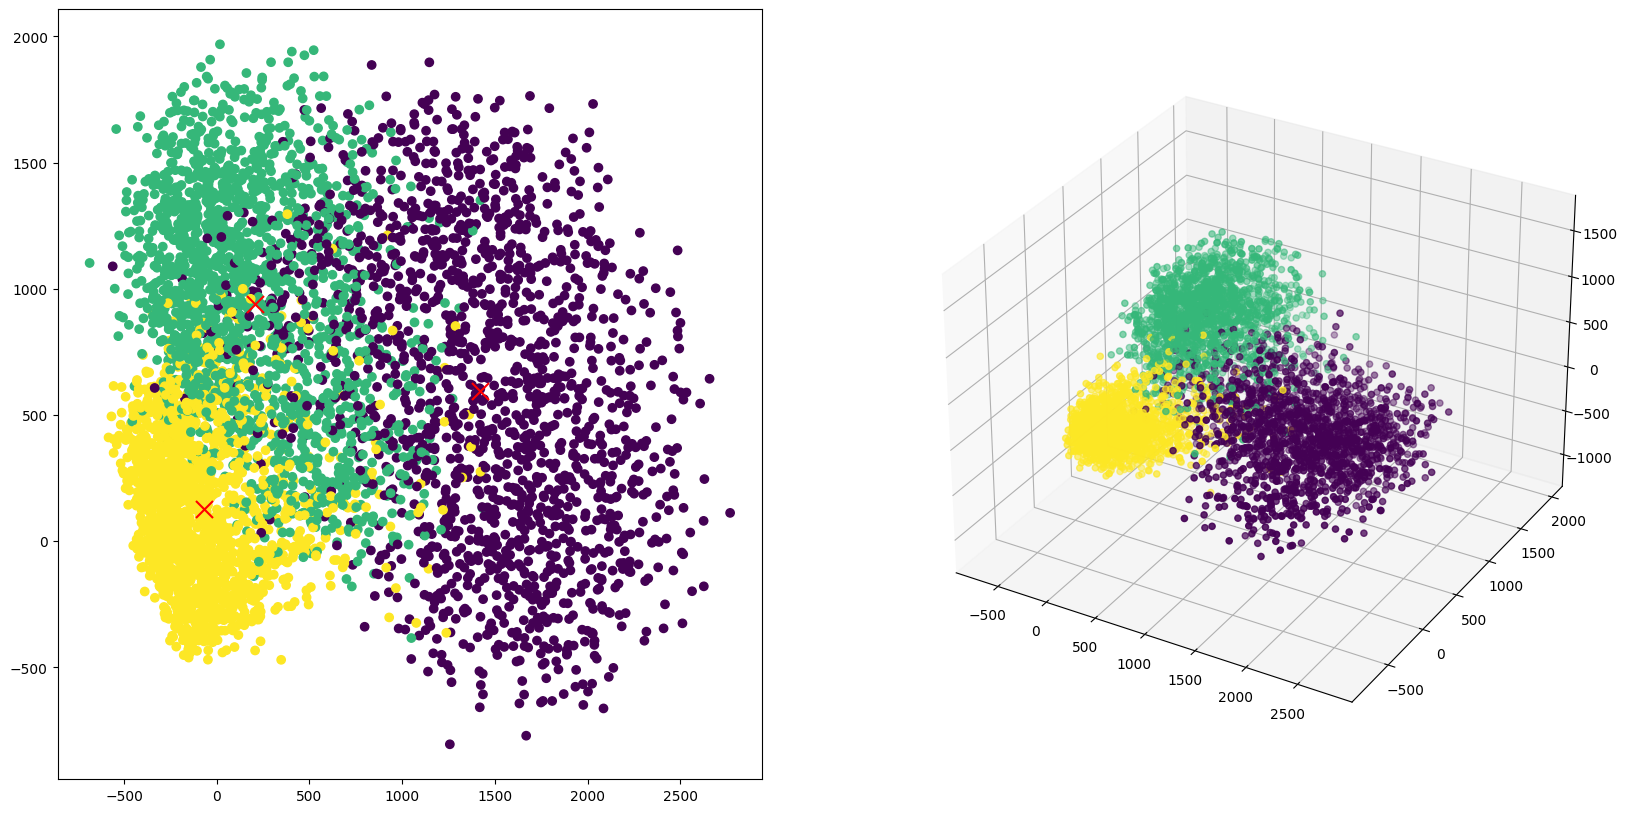

In [303]:
test_pca((X_train, Y_train, X_test, Y_test), digits=digits)

Cluster distance calculated in 2 dimension:
Cluster of digit 0 average distance from centroid in 2-Dimension: 0.002827922099774994
Cluster of digit 6 average distance from centroid in 2-Dimension: 0.002279258371018294
Cluster of digit 9 average distance from centroid in 2-Dimension: 0.005005545752415941

Cluster distance calculated in 3 dimension:
Cluster of digit 0 average distance from centroid in 3-Dimension: 0.00477929034035352
Cluster of digit 6 average distance from centroid in 3-Dimension: 0.0042818322960531865
Cluster of digit 9 average distance from centroid in 3-Dimension: 0.007373758801152052

Cluster distance calculated for the test set in 2 dimension:
Cluster of digit 0 average distance from centroid: 0.002405272760111412
Cluster of digit 6 average distance from centroid: 0.01460523649198743
Cluster of digit 9 average distance from centroid: 0.004127324458111636


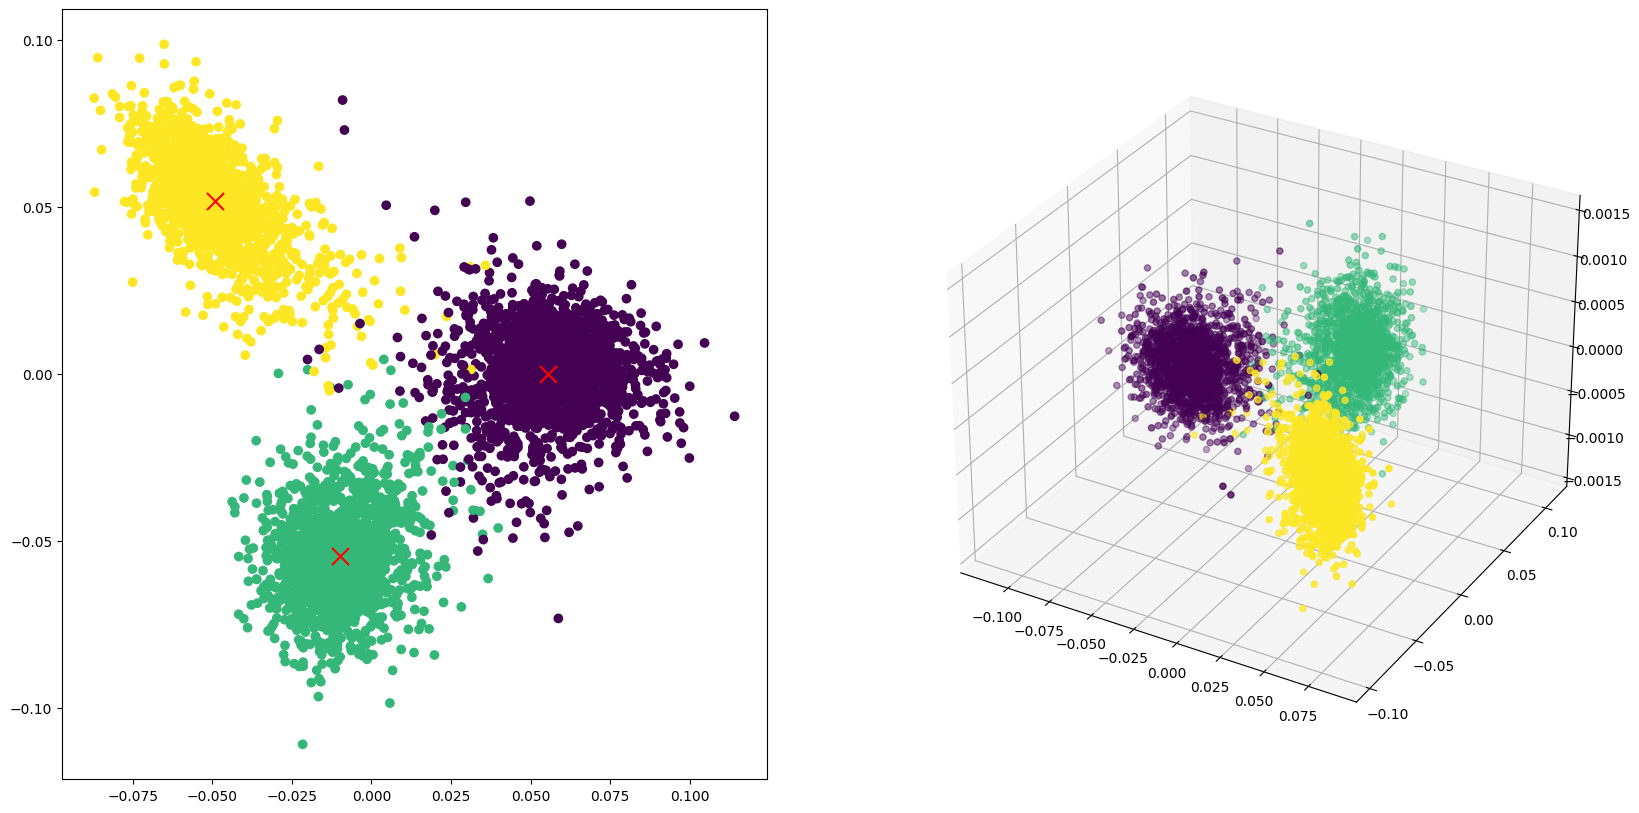

In [304]:
import scipy.sparse.linalg


def is_pos_def(X):
    return np.all(np.linalg.eigvals(X) > 0)

def LDA_projection_matrix(X, Y,  k):
    X_ks_centered = []

    labels = list(set(Y))
    for label in labels:
        X_k = X[:, Y == label]
        c_k = centroid(X_k)
        X_ks_centered.append(X_k - c_k)

    X_w = np.concatenate(X_ks_centered, axis=1)
    S_w = X_w @ X_w.T

    X_bars = []
    for label in labels:
        X_k = X[:, Y == label]
        c_k = centroid(X_k)
        X_bar = np.repeat(c_k, X_k.shape[1], axis=1)
        X_bars.append(X_bar)

    X_bar = np.concatenate(X_bars, axis=1)
    X_bar_centered = X_bar - centroid(X)

    S_b = X_bar_centered @ X_bar_centered.T


    if is_pos_def(S_w):
        L = np.linalg.cholesky(S_w)
    else:
        eps = 1e-6
        L = np.linalg.cholesky(S_w + eps * np.eye(S_w.shape[0]))

    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ S_b @ L, k=k)

    W = np.real(W)

    Q = np.linalg.inv(L).T @ W

    return Q

def LDA(X,Y, k):
    Q = LDA_projection_matrix(X, Y, k)
    return Q.T @ X


def test_lda(D, digits, fig = None):
    X_train, Y_train, X_test, Y_test = D

    Q_2d = LDA_projection_matrix(X_train, Y_train, k=2)
    Z_k_2d = Q_2d.T @ X_train
    projected_centroids_2d = Q_2d.T @ centroids


    average_cluster_distance_2d = average_cluster_distance(Z_k_2d, Y_train, projected_centroids_2d, digits=digits)
    print("Cluster distance calculated in 2 dimension:")
    for digit, average_distance in average_cluster_distance_2d.items():
        print(f"Cluster of digit {digit} average distance from centroid in 2-Dimension: {average_distance}")

    if not fig:
        fig = plt.figure(figsize = (20, 10))

    ax = fig.add_subplot(1,2,1)



    ax.scatter(Z_k_2d[0,:], Z_k_2d[1, :], c=Y_train)
    ax.scatter(projected_centroids_2d[:, 0, :], projected_centroids_2d[:, 1, :], c = "red", marker = "x", s=150)

    Q_3d = LDA_projection_matrix(X_train, Y_train, k=3)
    Z_k_3d = Q_3d.T @ X_train
    projected_centroids_3d = Q_3d.T @ centroids

    average_cluster_distance_3d = average_cluster_distance(Z_k_3d, Y_train, projected_centroids_3d, digits=digits)

    print("\nCluster distance calculated in 3 dimension:")
    for digit, average_distance in average_cluster_distance_3d.items():
        print(f"Cluster of digit {digit} average distance from centroid in 3-Dimension: {average_distance}")

    ax = fig.add_subplot(1,2,2, projection='3d')
    ax.scatter(Z_k_3d[0,:], Z_k_3d[1, :], Z_k_3d[2, :], c=Y_train)

    print("\nCluster distance calculated for the test set in 2 dimension:")

    test_set_projected = Q_2d.T @ X_test
    for digit, average_distance in average_cluster_distance(test_set_projected, Y_test, projected_centroids_2d, digits=digits).items():
        print(f"Cluster of digit {digit} average distance from centroid: {average_distance}")


test_lda((X_train, Y_train, X_test, Y_test), digits=digits)

In [305]:
def classificator(x, centroids, labels, P):
    projected_x = P.T @ x
    projected_x = projected_x.reshape((2,1))

    min_distance = np.inf
    current_label = -1

    for label, centroid in zip(labels, centroids):

        distance = np.linalg.norm(projected_x - centroid)

        if distance < min_distance:
            min_distance = distance
            current_label = label

    return current_label

def calculate_accuracy_of_classificator(X, Y, P, centroids, labels):
    correct_guess = 0
    for x, y in zip(X.T, Y):
        result = classificator(x, centroids, labels, P)

        if result == y:
            correct_guess = correct_guess + 1

    return correct_guess


def test_classificators_on_digits(digits):
    X, Y = get_X_Y_of_digits(digits)

    X_train, Y_train, X_test, Y_test = split_dataset(X, Y, int(Y.shape[0] * 0.7))

    pca_projection_matrix = PCA_projection_matrix(X_train, k=2)
    pca_centroids = calculate_centroids(pca_projection_matrix.T @ X_train, Y_train, digits)
    pca_correct_guess = calculate_accuracy_of_classificator(X_test, Y_test, pca_projection_matrix, pca_centroids, labels=digits)


    print(f"PCA accuracy = {pca_correct_guess / Y_test.shape[0] * 100} % ")

    lda_projection_matrix = LDA_projection_matrix(X_train, Y_train, k=2)
    lda_centroids = calculate_centroids(lda_projection_matrix.T @ X_train, Y_train, digits)
    lda_correct_guess = calculate_accuracy_of_classificator(X_test, Y_test, lda_projection_matrix, lda_centroids, labels=digits)

    print(f"LDA ccuracy = {lda_correct_guess / Y_test.shape[0] * 100} % ")




In [306]:
test_classificators_on_digits([0,6,9])


PCA accuracy = 84.45692883895131 % 
LDA ccuracy = 98.0203317281969 % 


## Experiment with other digits

PCA
Cluster distance calculated in 2 dimension:
Cluster of digit 3 average distance from centroid in 2-Dimension: 28.6210973208331
Cluster of digit 5 average distance from centroid in 2-Dimension: 32.01711002335837

Cluster distance calculated in 3 dimension:
Cluster of digit 3 average distance from centroid in 3-Dimension: 51.25802317182283
Cluster of digit 5 average distance from centroid in 3-Dimension: 59.63812831967151

Cluster distance calculated for the test set in 2 dimension:
Cluster of digit 3 average distance from centroid: 34.02506187873248
Cluster of digit 5 average distance from centroid: 39.662262052501305
LDA
Cluster distance calculated in 2 dimension:
Cluster of digit 3 average distance from centroid in 2-Dimension: 0.0017496098348435088
Cluster of digit 5 average distance from centroid in 2-Dimension: 0.0007615682030116107

Cluster distance calculated in 3 dimension:
Cluster of digit 3 average distance from centroid in 3-Dimension: 0.002967294133100889
Cluster of digi

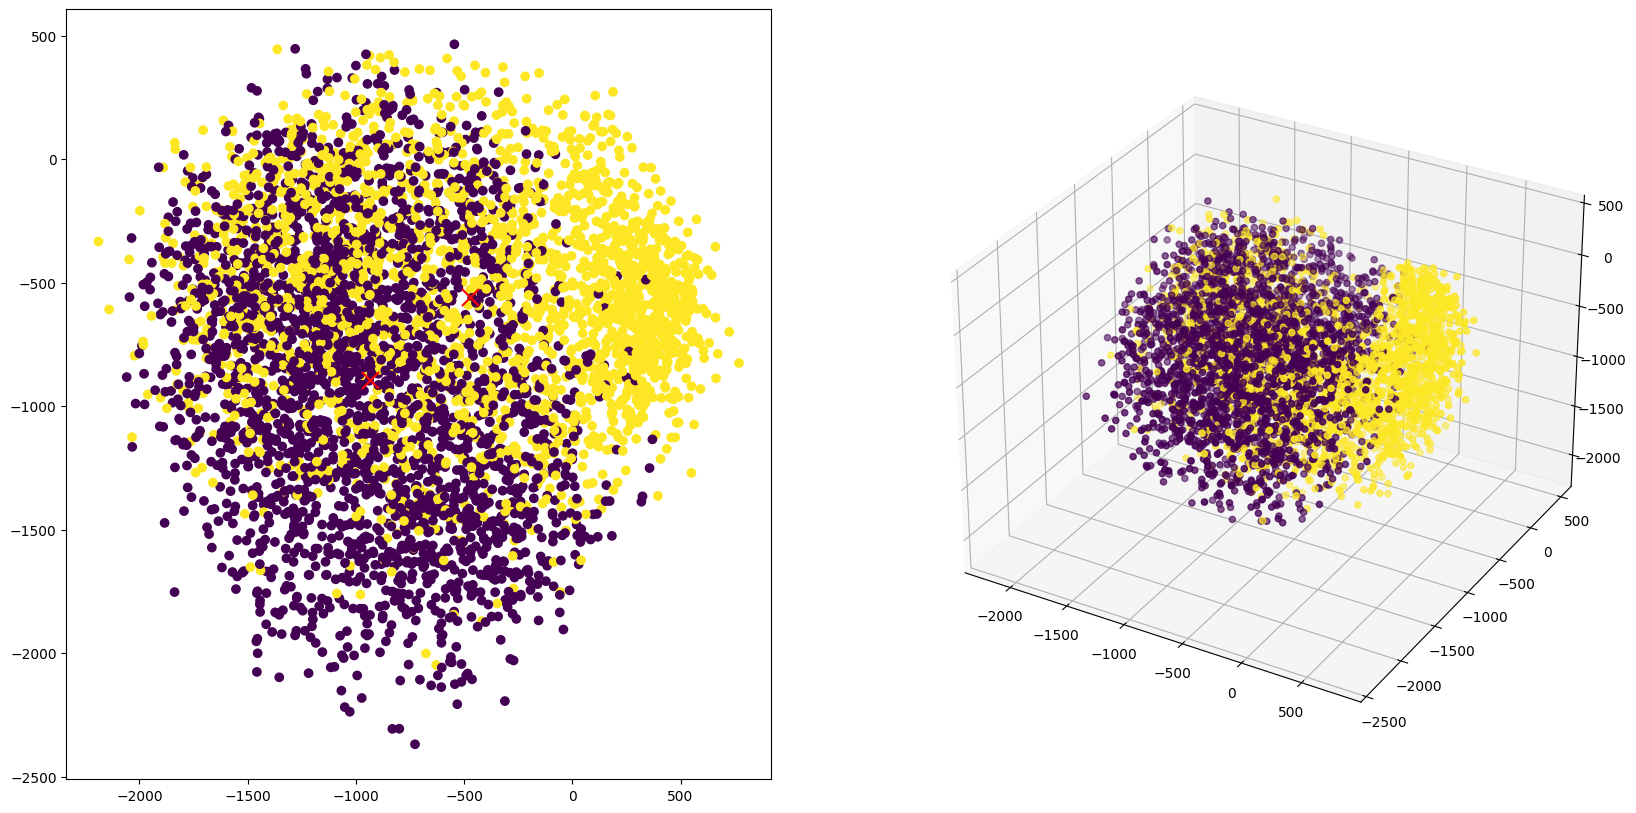

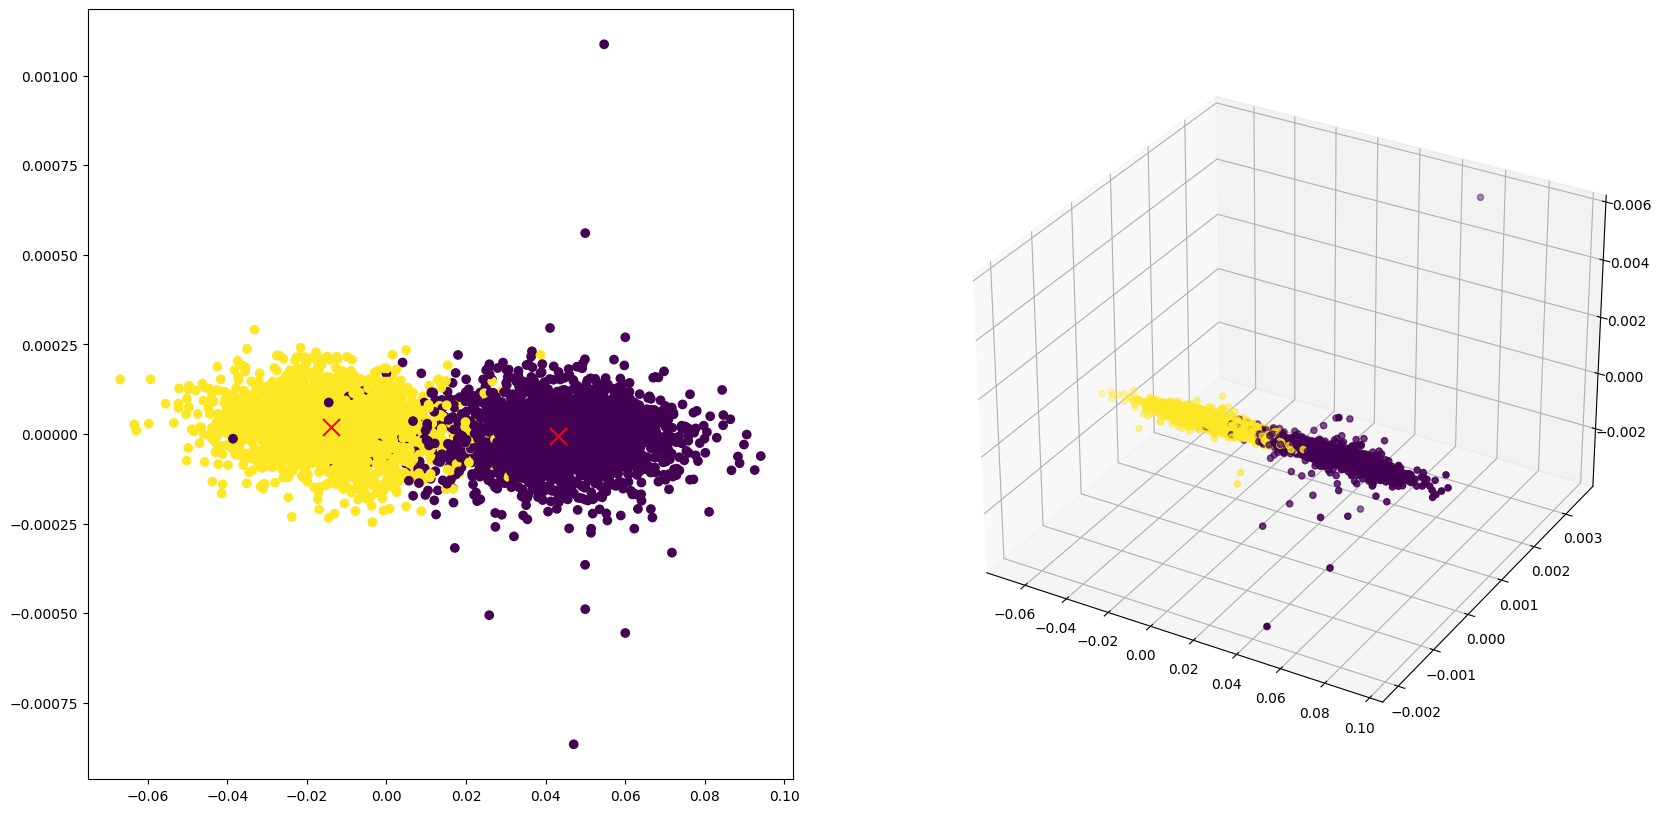

In [307]:
digits = [3, 5]
X, Y = get_X_Y_of_digits(digits)
X_train, Y_train, X_test, Y_test = split_dataset(X, Y, int(Y.shape[0]*0.6))
centroids = calculate_centroids(X_train, Y_train, digits)

print("PCA")
test_pca((X_train, Y_train, X_test, Y_test), digits=digits)

print("LDA")
test_lda((X_train, Y_train, X_test, Y_test), digits=digits)

test_classificators_on_digits([3,5])

<h1> Visualizing Dyad </h1>

image.shape=(512, 512)
U.shape=(512, 512)
s.shape=(512,)
VT.shape=(512, 512)


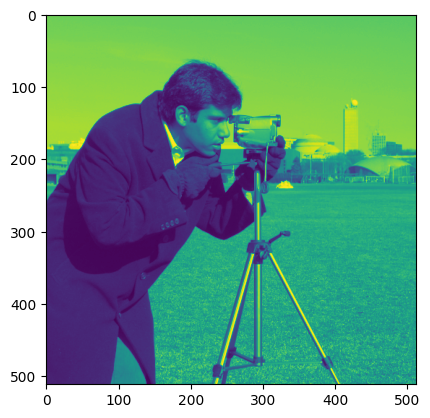

In [361]:
import skimage.data

image = skimage.data.camera()

m,n = image.shape
print(f"{image.shape=}")

U, s, VT = np.linalg.svd(image, full_matrices=True)

print(f"{U.shape=}")
print(f"{s.shape=}")
print(f"{VT.shape=}")

plt.imshow(image)


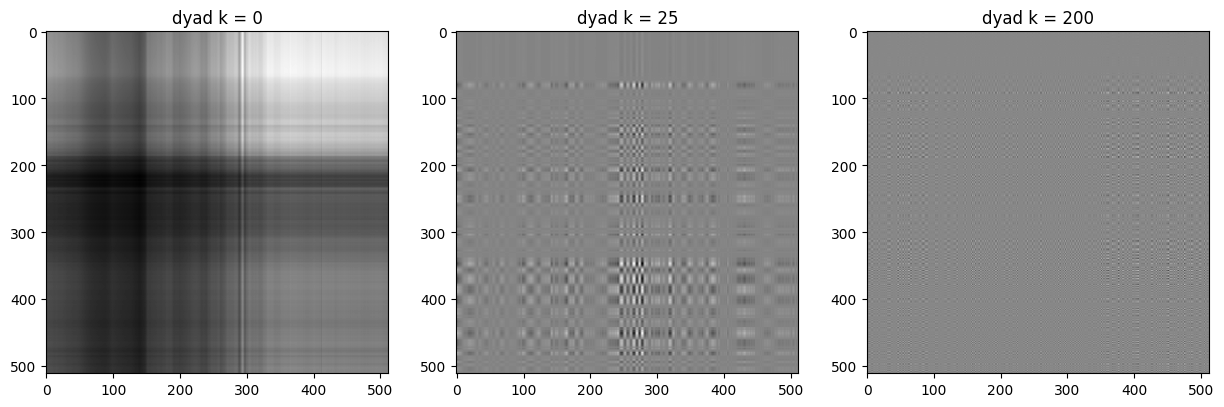

In [370]:
def dyad(i):
    return s[i] * (U[:, i].reshape((m,1)) @ VT[i, :].reshape((1,n)))

plt.figure(figsize=(15, 15))

ax = plt.subplot(1,3,1)
ax.imshow(dyad(0), cmap="gray")
ax.set_title("dyad k = 0")

ax = plt.subplot(1,3,2)
ax.imshow(dyad(25), cmap="gray")
ax.set_title("dyad k = 25")


ax = plt.subplot(1,3,3)
ax.imshow(dyad(200), cmap="gray")
ax.set_title("dyad k = 200");


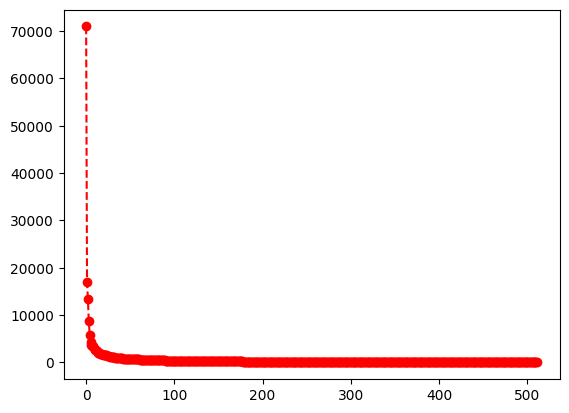

In [367]:
plt.plot(s, "--ro")

(512, 512)


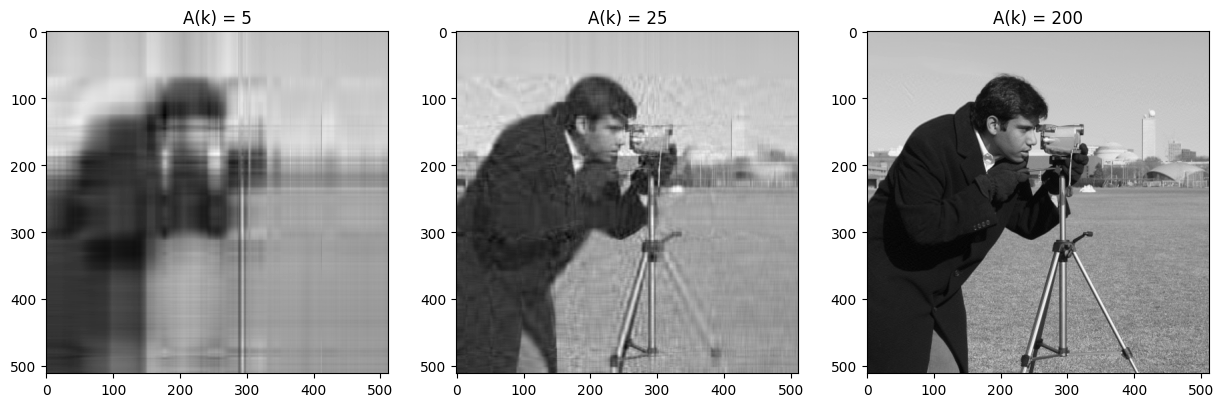

In [376]:
def k_rank_approximation(k):
    return np.sum([dyad(i) for i in range(k)], axis=0)

print(k_rank_approximation(5).shape)

plt.figure(figsize=(15, 15))

ax = plt.subplot(1,3,1)
ax.imshow(k_rank_approximation(5), cmap="gray")
ax.set_title("A(k) = 5")

ax = plt.subplot(1,3,2)
ax.imshow(k_rank_approximation(25), cmap="gray")
ax.set_title("A(k) = 25")


ax = plt.subplot(1,3,3)
ax.imshow(k_rank_approximation(200), cmap="gray")
ax.set_title("A(k) = 200");

Text(0.5, 1.0, 'Approximation error')

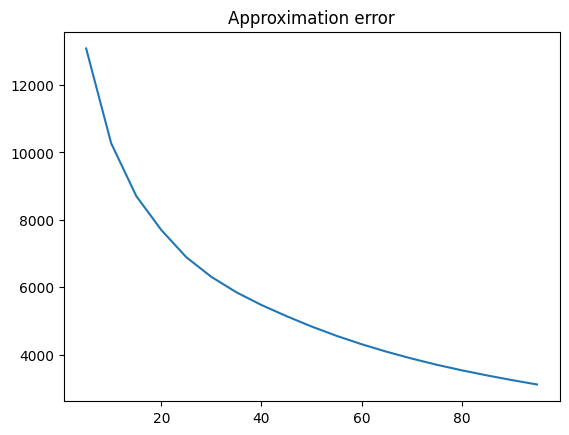

In [387]:
#print([np.linalg.norm(image - k_rank_approximation(k)) for k in range(5, 100, 5)])
plt.plot(range(5,100,5), [np.linalg.norm(image - k_rank_approximation(k)) for k in range(5, 100, 5)]);
plt.title("Approximation error")

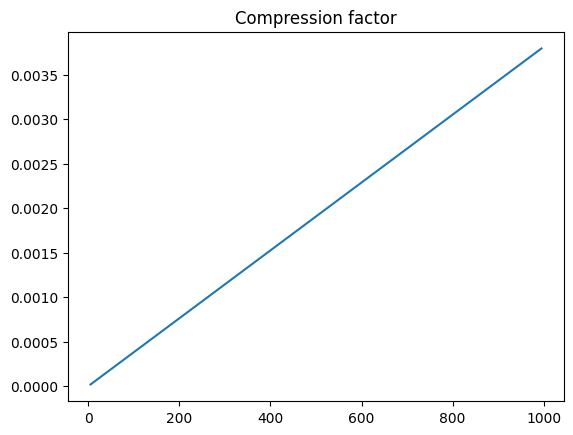

In [391]:
r = range(5,1000, 5)
plt.plot(r, [k / (m*n) for k in r]);
plt.title("Compression factor");